In [4]:
import numpy as np

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [5]:
def logit(z):
    return 1 / (1 + np.exp(-z))


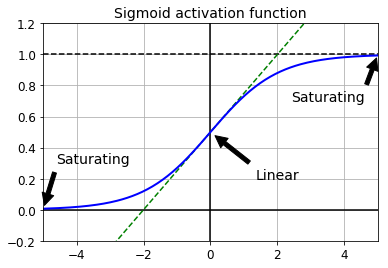

In [6]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()


In [7]:
import tensorflow as tf

In [8]:
reset_graph()

In [9]:
n_inputs = 28 * 28
n_hidden1 = 300
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")


In [11]:
#using He initializaton rather than Xavier (default for layers.dense)
he_init = tf.variance_scaling_initializer()

In [12]:

hidden1 =tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init,name="hidden1")

In [15]:
#preventing activation function saturating
#leaky relu
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)


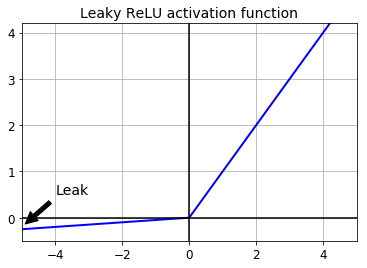

In [16]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [17]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [18]:
#implementing leaky relu in a layer
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1= tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [30]:
#training w/ leaky relu

reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [31]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [32]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [33]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [34]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [35]:
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [38]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
    

In [39]:
n_epochs = 40
batch_size = 50 

with tf.Session() as sess: 
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "batch accuracy:", acc_batch, "Validation acc:", acc_valid)
            
    save_path = saver.save(sess, "./DNNLeakReLu_final.ckpt")
            

0 batch accuracy: 0.86 Validation acc: 0.9044
5 batch accuracy: 0.94 Validation acc: 0.9496
10 batch accuracy: 0.92 Validation acc: 0.9654
15 batch accuracy: 0.94 Validation acc: 0.971
20 batch accuracy: 1.0 Validation acc: 0.9764
25 batch accuracy: 1.0 Validation acc: 0.9778
30 batch accuracy: 0.98 Validation acc: 0.978
35 batch accuracy: 1.0 Validation acc: 0.9788


In [40]:
file_writer= tf.summary.FileWriter("tf_logs/DNNLeakyReLu2", tf.get_default_graph())

In [41]:
#exponential linear unit for activation function
#more accurate usually but more computationally expensive
#can make up for cost with faster convergence rate

def elu(z, alpha=1):
    return np.where(z <0, alpha * (np.exp(z) - 1), z)

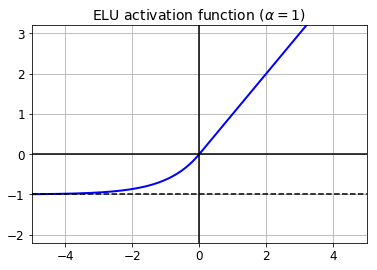

In [42]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

#nonzero gradient for z < 0
#smooth everywhere (faster gradient descent)
#tf has ELU 
#hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

In [43]:
#Scaled exponential linear units (self-normalizing around mean and variance, thus preventing vanishing gradients)
#outperforms regular ELUs 

def selu(z, scale=1.0507009873554804934193349852946, alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)
    

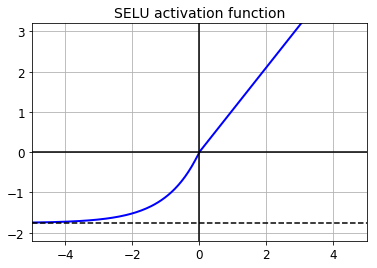

In [44]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()


In [46]:
# demonstrating self normalization of function (mean close to 0, std dev close to 1 across all layers)
np.random.seed(42)
Z = np.random.normal(size=(500,100))
for layer in range(100):
    W = np.random.normal(size=(100,100), scale = np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


In [49]:
#net with SeLU

reset_graph()

n_inputs = 28*28

n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(np.float32, shape=(None, n_inputs), name= "X")
y = tf.placeholder(np.int32, shape=(None), name = "y")

with tf.name_scope("SeLu_DNN"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate= 0.01
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50


In [50]:
#for scaling inputs to mean 0 and stddev 1
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means)/ stds


In [53]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "batch acc:", acc_batch, "Val acc:", acc_valid)
    
    save_path = saver.save(sess, "./DNNSeLu_final.ckpt")

0 batch acc: 0.92 Val acc: 0.9194
5 batch acc: 0.96 Val acc: 0.9546
10 batch acc: 0.98 Val acc: 0.9638
15 batch acc: 0.96 Val acc: 0.9678
20 batch acc: 1.0 Val acc: 0.9682
25 batch acc: 1.0 Val acc: 0.9688
30 batch acc: 1.0 Val acc: 0.9714
35 batch acc: 1.0 Val acc: 0.9718


In [54]:
file_writer= tf.summary.FileWriter("tf_logs/DNNSeLu", tf.get_default_graph())

In [60]:
#batch normalization, another technique to combat vanishing gradients
#learns optimal scale and mean of inputs for each layer, shifts/scales data set to normalize to those parameters
# less sensitive to weight initialization, can learn at higher rates
#runtime penalty, by virtue of a more complicated model, the predictions are slower
reset_graph()

from functools import partial

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

batch_norm_momentum=0.99


In [61]:
#net with elu activation, He init and batch norm at each layer
with tf.name_scope("BN_DNN"):
    he_init = tf.variance_scaling_initializer()
    
    batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
    
    dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    
    hidden1 = dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(batch_norm_layer(hidden1))
    hidden2 = dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(batch_norm_layer(hidden2))
    logits_before_bn = dense_layer(bn2, n_outputs, name="outputs")
    logits = batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [63]:
n_epochs = 20
batch_size= 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training:True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "./BN_DNN_final.ckpt")
    

0 Validation accuracy: 0.8982
1 Validation accuracy: 0.9264
2 Validation accuracy: 0.938
3 Validation accuracy: 0.9464
4 Validation accuracy: 0.952
5 Validation accuracy: 0.957
6 Validation accuracy: 0.9618
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9666
9 Validation accuracy: 0.9682
10 Validation accuracy: 0.9686
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.9708
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9736
15 Validation accuracy: 0.9728
16 Validation accuracy: 0.9734
17 Validation accuracy: 0.9748
18 Validation accuracy: 0.9758
19 Validation accuracy: 0.9752


In [64]:
file_writer= tf.summary.FileWriter("tf_logs/BN_DNN", tf.get_default_graph())

In [114]:
#gradient clipping for exploding gradients - useful for RNN

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate= 0.01

In [115]:
#normally here you'd have a normal op[timizer but .minimize() computes gradients and applies them, so 
#to clip you need compute seperately

with tf.name_scope("train"):
    threshold = 1.0
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
    training_op = optimizer.apply_gradients(capped_gvs)
    

In [116]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32), name="accuracy")

In [117]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [118]:
n_epochs = 20
batch_size = 200

In [119]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y: y_valid})
        print(epoch, "val acc:", accuracy_val)
        
    save_path = saver.save(sess, "./DNN_grad_clip_final.ckpt")

0 val acc: 0.288
1 val acc: 0.7936
2 val acc: 0.8798
3 val acc: 0.906
4 val acc: 0.9164
5 val acc: 0.9218
6 val acc: 0.9296
7 val acc: 0.9358
8 val acc: 0.9382
9 val acc: 0.9414
10 val acc: 0.9456
11 val acc: 0.9474
12 val acc: 0.9478
13 val acc: 0.9534
14 val acc: 0.9568
15 val acc: 0.9566
16 val acc: 0.9574
17 val acc: 0.959
18 val acc: 0.9622
19 val acc: 0.9612


In [75]:
file_writer= tf.summary.FileWriter("tf_logs/GC_DNN", tf.get_default_graph())


In [90]:
reset_graph()

In [91]:
saver = tf.train.import_meta_graph("./DNN_grad_clip_final.ckpt.meta")

In [92]:
#this prints all graph ops, a good way to sort through these is to view in tensorboard to see which you need
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [93]:
#functions for selecting particular tensors/ops once you know what you need
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

In [94]:
#for easier access you can group important ops for quick re-use (no searching)

#for op in (X, y, accuracy, training_op):
    #tf.add_to_collection("important_ops", op)
    
#to grab this collection later (after importing the meta graph)
#X, y, accuracy, training_op = tf.get_collection("my_important_ops")



In [97]:
#continue training after restoring session on pre trained model
with tf.Session() as sess:
    #restore graph state
    saver.restore(sess, "./DNN_grad_clip_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./Grad_clip_restored_final.ckpt")
    
    

INFO:tensorflow:Restoring parameters from ./DNN_grad_clip_final.ckpt
0 Validation accuracy: 0.9632
1 Validation accuracy: 0.9648
2 Validation accuracy: 0.9646
3 Validation accuracy: 0.9644
4 Validation accuracy: 0.9666
5 Validation accuracy: 0.967
6 Validation accuracy: 0.968
7 Validation accuracy: 0.9664
8 Validation accuracy: 0.9662
9 Validation accuracy: 0.9712
10 Validation accuracy: 0.9672
11 Validation accuracy: 0.9708
12 Validation accuracy: 0.971
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.9698
15 Validation accuracy: 0.9698
16 Validation accuracy: 0.971
17 Validation accuracy: 0.969
18 Validation accuracy: 0.9724
19 Validation accuracy: 0.9716


In [131]:
# previous model had 5 hidden layers and 1 output layer; here we will take those first 3 trained layers
# and train a new 4th hidden and output, as well as a new loss and optimizer
reset_graph()

n_hidden4 = 20  
n_outputs = 10 

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [132]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9576
1 Validation accuracy: 0.9666
2 Validation accuracy: 0.9694
3 Validation accuracy: 0.9708
4 Validation accuracy: 0.9722
5 Validation accuracy: 0.9726
6 Validation accuracy: 0.9752
7 Validation accuracy: 0.9748
8 Validation accuracy: 0.9754
9 Validation accuracy: 0.9756
10 Validation accuracy: 0.9756
11 Validation accuracy: 0.9758
12 Validation accuracy: 0.975
13 Validation accuracy: 0.9756
14 Validation accuracy: 0.9756
15 Validation accuracy: 0.9768
16 Validation accuracy: 0.9764
17 Validation accuracy: 0.9764
18 Validation accuracy: 0.9762
19 Validation accuracy: 0.9774


In [183]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       #old
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") #old
    #using this stop gradient will freeze all layers below it, and then you can have normal train functions
    #hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") #old
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") #new
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         #new

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
#only giving higher level (hidden4 + output) variables to train
with tf.name_scope("train"):                                        
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [184]:

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars) # restore layers 1-3 (they are frozen and will not be trained)

init = tf.global_variables_initializer()
saverold = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


NotFoundError: Key hidden1/bias not found in checkpoint
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]

Caused by op 'save_1/RestoreV2', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-184-a81a2e1dfc56>", line 7, in <module>
    restore_saver = tf.train.Saver(reuse_vars) # restore layers 1-3 (they are frozen and will not be trained)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1284, in __init__
    self.build()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 400, in _AddRestoreOps
    restore_sequentially)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 832, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key hidden1/bias not found in checkpoint
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]


In [147]:
#caching the output of frozen layers can significantly improve training time 
#instead of building batches of input data, you can build batches of cached output data at the end of frozen layers 
#and feed it to new layers



In [175]:
reset_graph()

n_inputs = 28 * 28  
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,name="hidden1") 
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") 
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") 

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    

In [176]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") 
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
newsaver = tf.train.Saver()

In [179]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) 

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})             
        print(epoch, "Validation accuracy:", accuracy_val)              

    save_path = newsaver.save(sess, "./DNN_reused_with_cached_layers.final.ckpt")
    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


NotFoundError: Key hidden1/bias not found in checkpoint
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_1_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-176-7efcb9245e1f>", line 2, in <module>
    restore_saver = tf.train.Saver(reuse_vars)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1284, in __init__
    self.build()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 400, in _AddRestoreOps
    restore_sequentially)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 832, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key hidden1/bias not found in checkpoint
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_1_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [187]:
#different types of optimizers (faster to find global minima)
#momentum optimizer (converges faster, can overshoot. friction hyperparam keeps in check(value between 0-1))
MomOptimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

#Nesterov Accelerated Gradient 
#like momentum but it measures gradient of cost function not at local position but slightly ahead in the direction of the momentum

NAGOptimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

#adaptive gradient (AdaGrad)
#scales down gradient vector along steepest dimensions, decays learning rate (faster for steep dimensions than gentle slopes)
#good for simple quadratics, often stops at local minima rather than global for DNNs

AdaOptimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

#RMSprop is a fix to adagrad slowing down too fast to find global, only accumulates gradients from recent iterations
#an alternative is AdaDelta

RMSOptimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

#ADAM optimization, essentially a combo of RMSprop and momentum, keeps track of both expon. decaying avg of past gradients (momentum)
# and a exponentially decaying avg of past squared gradients (rms)
#momen decay init to 0.9, scaling decay init to 0.999, smoothing term 1e-10
#good improvement is NAdam, which uses Nesterov momentum. Don't think this is built into TF yet though

ADAMOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#overview of optimizers for reference 
# http://ruder.io/optimizing-gradient-descent/

In [188]:
# learning rate scheduling (predefined decay of learning rate to prevent divergence, failure to find optimum 
# or going back and forth over optimum)

#normal net, loss and eval for dnn
reset_graph()

n_inputs = 28 * 28  
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden1, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, activation=tf.nn.relu, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    

In [192]:
#train is where the learning rate decay comes in
#remember Adagrad RMSprop and ADAM optimization already contain learning scheduling

with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.9)
    training_op = optimizer.minimize(loss, global_step = global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 10
batch_size=100

In [196]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "acc val:", accuracy_val)
        
    save_path = saver.save(sess, "./Learning_Rate_DNN_final.ckpt")



0 acc val: 0.9662
1 acc val: 0.9734
2 acc val: 0.9794
3 acc val: 0.977
4 acc val: 0.9846
5 acc val: 0.985
6 acc val: 0.985
7 acc val: 0.9846
8 acc val: 0.9858
9 acc val: 0.986


In [205]:
#avoiding overfitting
#obvious early stopping is an option (already done this)
#l1 and l2 regularization constrains connection weights

reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")
scale = 0.001 #regularization hyperparameter
    
#total loss= cross entropy loss and the l1 loss 


In [206]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits = logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")
                               
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(loss)
                               
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [207]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print( epoch, "val acc:", accuracy_val)

    save_path = saver.save(sess, "./Regularization_DNN_final.ckpt")
            

0 val acc: 0.9054
1 val acc: 0.9044
2 val acc: 0.902
3 val acc: 0.9084
4 val acc: 0.9092
5 val acc: 0.9124
6 val acc: 0.9196
7 val acc: 0.9196
8 val acc: 0.9218
9 val acc: 0.9264
10 val acc: 0.927
11 val acc: 0.9298
12 val acc: 0.9288
13 val acc: 0.9308
14 val acc: 0.932
15 val acc: 0.9322
16 val acc: 0.9342
17 val acc: 0.9356
18 val acc: 0.936
19 val acc: 0.9344


In [208]:
# a more efficient way to implement this is to create a partial representing a dense layer with kernel regularizer
# thus resolving the need for computing regularization in the loss function, it can just be referenced through GraphKeys

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

scale = 0.001

In [210]:
# using partial for new dense layer

dense_layer_w_reg = partial(
    tf.layers.dense, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = dense_layer_w_reg(X, n_hidden1, name="hidden1")
    hidden2 = dense_layer_w_reg(hidden1, n_hidden2, name="hidden2")
    hidden3 = dense_layer_w_reg(hidden2, n_hidden3, name="hidden3")
    logits = dense_layer_w_reg(hidden3, n_outputs, activation=None, name="outputs")

In [212]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="base_loss")
    #still need to add in reg losses but don't have to compute them here
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [213]:
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(loss)

In [214]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 20
batch_size= 200


In [215]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y: y_valid})
        print(epoch, "val acc:", accuracy_val)
        
    save_path = saver.save(sess, "./Kernel_Reg_DNN_final.ckpt")

0 val acc: 0.919
1 val acc: 0.9244
2 val acc: 0.9224
3 val acc: 0.9278
4 val acc: 0.9346
5 val acc: 0.937
6 val acc: 0.9406
7 val acc: 0.9428
8 val acc: 0.9474
9 val acc: 0.9438
10 val acc: 0.9482
11 val acc: 0.9496
12 val acc: 0.943
13 val acc: 0.9522
14 val acc: 0.9512
15 val acc: 0.9482
16 val acc: 0.9506
17 val acc: 0.9506
18 val acc: 0.9504
19 val acc: 0.9472


In [218]:
#dropout, the most popular regularization technique, involves randomly dropping a percentage (p) of neurons at every 
#training step, forcing the remaining neurons to compensate and thus become better at generalizing
#it is important to remember the weights must be multiplied by the keep probability (1-p) at the end, otherwise their
#signals would be too strong because their are double the amount of neurons when testing vs training
#slower convergence, better model

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name="training")
dropout_rate=0.5 
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop= tf.layers.dropout(hidden1, dropout_rate, training=training)
    
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop= tf.layers.dropout(hidden2, dropout_rate, training=training)
    
    hidden3 = tf.layers.dense(hidden2_drop, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden3_drop= tf.layers.dropout(hidden3, dropout_rate, training=training)
    
    logits = tf.layers.dense(hidden3_drop, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 50

In [219]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./Dropout_DNN_Final.ckpt")

0 Validation accuracy: 0.9062
1 Validation accuracy: 0.9388
2 Validation accuracy: 0.9496
3 Validation accuracy: 0.9538
4 Validation accuracy: 0.9568
5 Validation accuracy: 0.9602
6 Validation accuracy: 0.964
7 Validation accuracy: 0.9648
8 Validation accuracy: 0.966
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9674
12 Validation accuracy: 0.9696
13 Validation accuracy: 0.9706
14 Validation accuracy: 0.971
15 Validation accuracy: 0.97
16 Validation accuracy: 0.9698
17 Validation accuracy: 0.9704
18 Validation accuracy: 0.9706
19 Validation accuracy: 0.9704


In [220]:
file_writer= tf.summary.FileWriter("tf_logs/DNN_Dropout", tf.get_default_graph())

In [230]:
#regularization by weight clipping

def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None
    return max_norm

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [231]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [233]:
n_epochs=20
batch_size=200

clip_all_weights= tf.get_collection("max_norm")

with tf.Session() as sess: 
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch, in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)               

    save_path = saver.save(sess, "./Clip_DNN_final.ckpt")           

0 Validation accuracy: 0.9226
1 Validation accuracy: 0.9428
2 Validation accuracy: 0.9494
3 Validation accuracy: 0.9614
4 Validation accuracy: 0.9636
5 Validation accuracy: 0.9664
6 Validation accuracy: 0.9712
7 Validation accuracy: 0.9738
8 Validation accuracy: 0.973
9 Validation accuracy: 0.9742
10 Validation accuracy: 0.9748
11 Validation accuracy: 0.9776
12 Validation accuracy: 0.9746
13 Validation accuracy: 0.9754
14 Validation accuracy: 0.978
15 Validation accuracy: 0.9798
16 Validation accuracy: 0.9798
17 Validation accuracy: 0.9782
18 Validation accuracy: 0.9798
19 Validation accuracy: 0.9794


In [ ]:
#another good regularization technique is data augmentation: i.e. expanding your data set by generating skewed 
#versions of your original data. for example, if i had a set of images, i could crop them, rotate them, change 
#hue/saturation etc. etc. to generate more instance with variance that would allow the model to learn more generalizable
# features. Could be useful on GAN project